In [3]:
import os
import pandas as pd
folder_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery"
# 列出所有 CSV 文件
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
print(f"共找到 {len(csv_files)} 个文件")
print(csv_files[:5])  # 示例：打印前5个文件名

共找到 66 个文件
['CY25-05_1-#3.csv', 'CY45-05_1-#10.csv', 'CY25-025_1-#1.csv', 'CY45-05_1-#17.csv', 'CY45-05_1-#11.csv']


In [5]:
import pandas as pd
file_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery/CY25-025_1-#1.csv"
df = pd.read_csv(file_path, nrows=10)
print(df.head())
print("\n列信息：")
print(df.dtypes)

   time/s  control/V/mA   Ecell/V      <I>/mA  Q discharge/mA.h  \
0   0.000         875.0  3.098623    0.848889               0.0   
1   0.220         875.0  3.103623  874.760337               0.0   
2   1.404         875.0  3.108624  874.908625               0.0   
3   3.156         875.0  3.113624  874.934011               0.0   
4   5.294         875.0  3.118624  874.938549               0.0   

   Q charge/mA.h  control/V  control/mA  cycle number  
0       0.000485        0.0       875.0           1.0  
1       0.053943        0.0       875.0           1.0  
2       0.341691        0.0       875.0           1.0  
3       0.767492        0.0       875.0           1.0  
4       1.287108        0.0       875.0           1.0  

列信息：
time/s              float64
control/V/mA        float64
Ecell/V             float64
<I>/mA              float64
Q discharge/mA.h    float64
Q charge/mA.h       float64
control/V           float64
control/mA          float64
cycle number        float64
dty

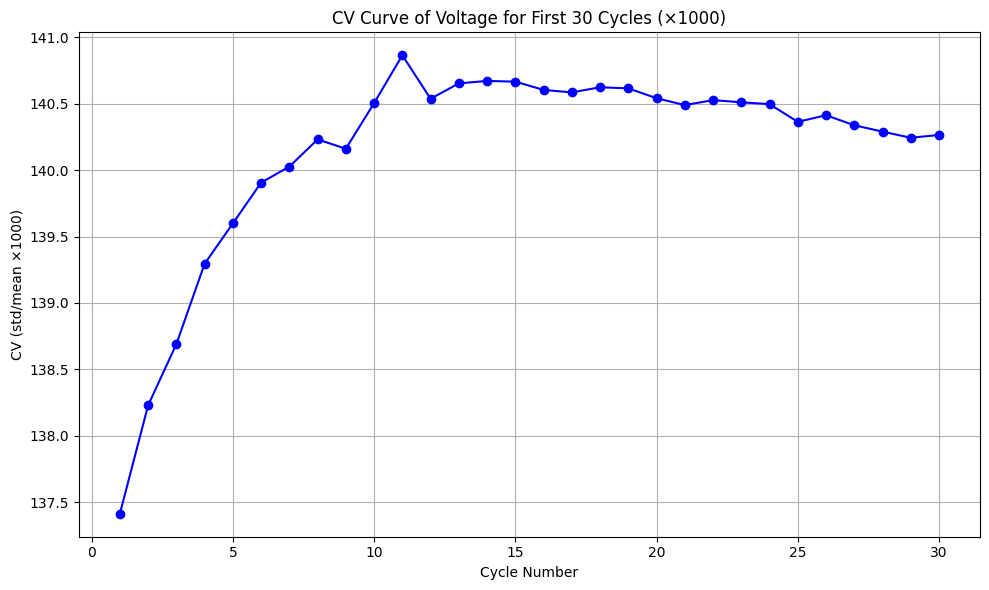

In [ ]:
# 不区分状态绘制CV曲线
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: 读取数据 ===
file_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery/CY25-025_1-#1.csv"
df = pd.read_csv(file_path)

# === Step 2: 重命名列，便于操作 ===
df = df.rename(columns={
    'Ecell/V': 'Voltage_V',
    'cycle number': 'Cycle'
})

# === Step 3: 丢弃缺失值，确保数据稳定 ===
df = df.dropna(subset=['Voltage_V', 'Cycle'])

# === Step 4: 计算每个循环的 CV ===
cv_stats = df.groupby('Cycle').agg(
    mean_voltage=('Voltage_V', 'mean'),
    std_voltage=('Voltage_V', 'std')
).reset_index()

cv_stats['std_to_mean_ratio'] = cv_stats['std_voltage'] / cv_stats['mean_voltage']
cv_stats['CV_x1000'] = cv_stats['std_to_mean_ratio'] * 1000

# === Step 5: 保留前30个循环 ===
cv_stats_30 = cv_stats[cv_stats['Cycle'] <= 30]

# === Step 6: 绘图 ===
plt.figure(figsize=(10, 6))
plt.plot(cv_stats_30['Cycle'], cv_stats_30['CV_x1000'], marker='o', linestyle='-', color='blue')
plt.title("CV Curve of Voltage for First 30 Cycles (×1000)")
plt.xlabel("Cycle Number")
plt.ylabel("CV (std/mean ×1000)")
plt.grid(True)
plt.tight_layout()
plt.show()

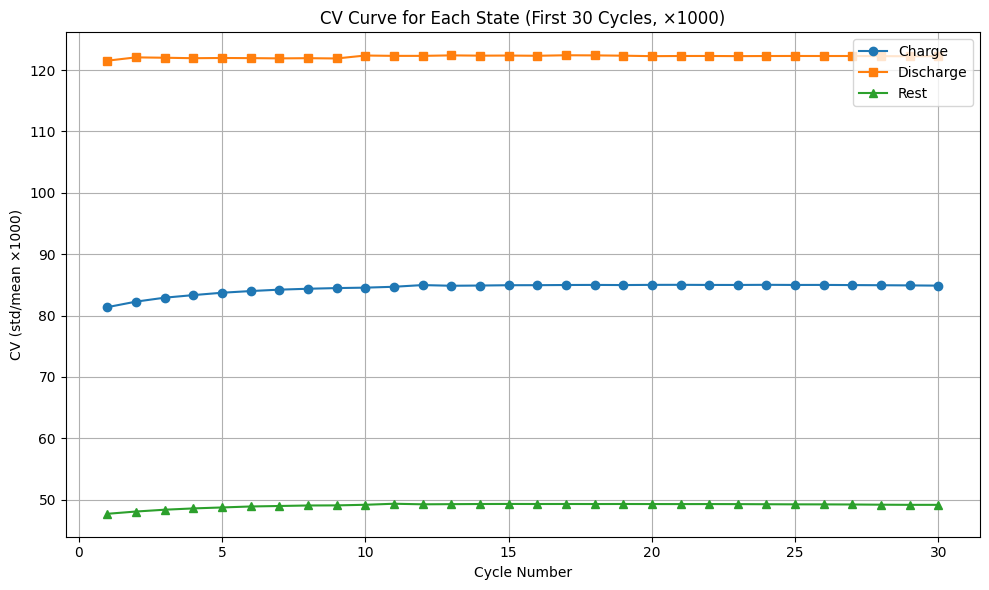

In [ ]:
# 分三种状态绘制CV曲线
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 读取数据 ===
file_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery/CY25-025_1-#1.csv"
df = pd.read_csv(file_path)

# === 创建状态列（根据电流划分）===
df['Current'] = df['<I>/mA']

def classify_state(i):
    if i > 10:
        return 'Charge'
    elif i < -10:
        return 'Discharge'
    else:
        return 'Rest'

df['State'] = df['Current'].apply(classify_state)

# === 仅保留必要的列，并确保列名一致 ===
df = df[['cycle number', 'State', 'Ecell/V']].dropna()
df.rename(columns={'cycle number': 'Cycle', 'Ecell/V': 'Voltage'}, inplace=True)

# === 计算CV的函数 ===
def compute_cv_by_state(df, target_state):
    df_filtered = df[df['State'] == target_state]
    grouped = df_filtered.groupby('Cycle')
    
    results = []
    for cycle, group in grouped:
        if cycle > 30:
            continue
        voltages = group['Voltage'].dropna().values
        if len(voltages) < 3:
            continue
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({'Cycle': cycle, 'CV': ratio * 1000})  # ×1000
    return pd.DataFrame(results)

# === 计算每个状态的CV ===
cv_charge = compute_cv_by_state(df, 'Charge')
cv_dchg = compute_cv_by_state(df, 'Discharge')
cv_rest = compute_cv_by_state(df, 'Rest')

# === 可视化 ===
plt.figure(figsize=(10, 6))
plt.plot(cv_charge['Cycle'], cv_charge['CV'], label='Charge', marker='o')
plt.plot(cv_dchg['Cycle'], cv_dchg['CV'], label='Discharge', marker='s')
plt.plot(cv_rest['Cycle'], cv_rest['CV'], label='Rest', marker='^')
plt.title('CV Curve for Each State (First 30 Cycles, ×1000)')
plt.xlabel('Cycle Number')
plt.ylabel('CV (std/mean ×1000)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 将全部数据合并
import os
import pandas as pd
folder_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery"
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# 初始化一个列表来存放每个读取的数据框
all_dataframes = []

# 遍历每个文件并读取
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        df = pd.read_csv(file_path)
        df['Source_File'] = file_name  # 添加来源列，方便追踪每行数据来自哪个文件
        all_dataframes.append(df)
    except Exception as e:
        print(f"读取文件 {file_name} 时出错：{e}")

# 合并为一个大数据框
combined_df = pd.concat(all_dataframes, ignore_index=True)

# 查看合并后的基本信息
print("合并后的数据预览：")
print(combined_df.head())
print(f"总行数：{len(combined_df)}，总列数：{combined_df.shape[1]}")

# 可选：保存为一个新的 CSV 文件
output_path = os.path.join(folder_path, "combined_all_battery_data.csv")
combined_df.to_csv(output_path, index=False)
print(f"✅ 合并完成，保存为：{output_path}")

合并后的数据预览：
   time/s  control/V/mA   Ecell/V       <I>/mA  Q discharge/mA.h  \
0   0.000        1750.0  3.119510     0.029097               0.0   
1   0.052        1750.0  3.124668  1748.053205               0.0   
2   0.374        1750.0  3.129669  1748.448962               0.0   
3   0.978        1750.0  3.134669  1748.536150               0.0   
4   1.756        1750.0  3.139670  1748.526481               0.0   

   Q charge/mA.h  control/V  control/mA  cycle number       Source_File  
0       0.000971        0.0      1750.0           1.0  CY25-05_1-#3.csv  
1       0.026220        0.0      1750.0           1.0  CY25-05_1-#3.csv  
2       0.182609        0.0      1750.0           1.0  CY25-05_1-#3.csv  
3       0.475975        0.0      1750.0           1.0  CY25-05_1-#3.csv  
4       0.853851        0.0      1750.0           1.0  CY25-05_1-#3.csv  
总行数：19235196，总列数：10
✅ 合并完成，保存为：/home/newuser/Documents/Battery/Dataset_1_NCA_battery/combined_all_battery_data.csv


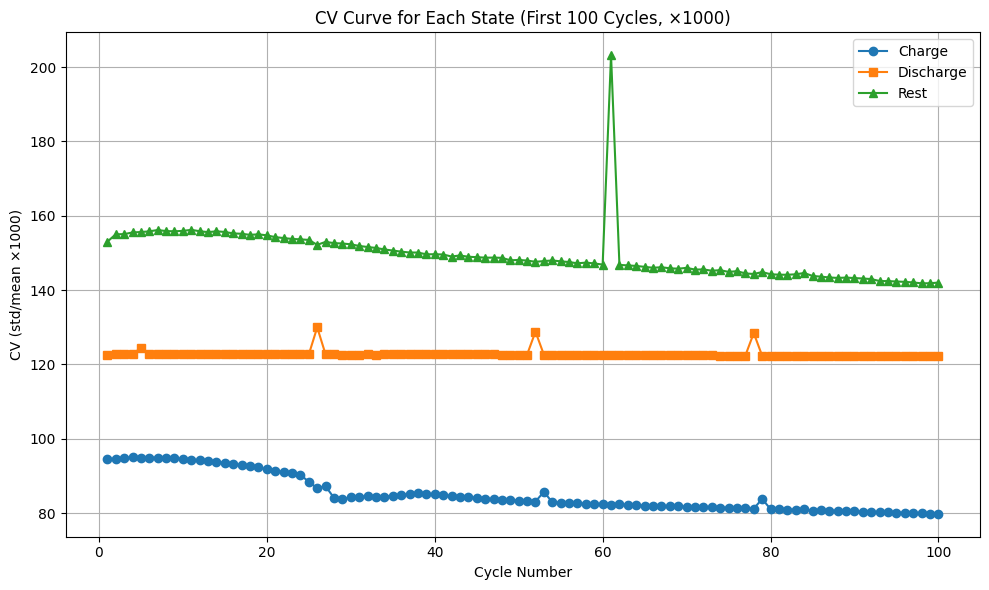

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === 读取数据 ===
file_path = "/home/newuser/Documents/Battery/Dataset_1_NCA_battery/combined_all_battery_data.csv"
df = pd.read_csv(file_path)

# === 创建状态列（根据电流划分）===
df['Current'] = df['<I>/mA']

def classify_state(i):
    if i > 10:
        return 'Charge'
    elif i < -10:
        return 'Discharge'
    else:
        return 'Rest'

df['State'] = df['Current'].apply(classify_state)

# === 仅保留必要的列，并确保列名一致 ===
df = df[['cycle number', 'State', 'Ecell/V']].dropna()
df.rename(columns={'cycle number': 'Cycle', 'Ecell/V': 'Voltage'}, inplace=True)

# === 计算CV的函数 ===
def compute_cv_by_state(df, target_state):
    df_filtered = df[df['State'] == target_state]
    grouped = df_filtered.groupby('Cycle')
    
    results = []
    for cycle, group in grouped:
        if cycle > 100:
            continue
        voltages = group['Voltage'].dropna().values
        if len(voltages) < 3:
            continue
        mean_v = np.mean(voltages)
        if mean_v == 0:
            continue
        std_v = np.std(voltages)
        ratio = std_v / mean_v
        results.append({'Cycle': cycle, 'CV': ratio * 1000})  # ×1000
    return pd.DataFrame(results)

# === 计算每个状态的CV ===
cv_charge = compute_cv_by_state(df, 'Charge')
cv_dchg = compute_cv_by_state(df, 'Discharge')
cv_rest = compute_cv_by_state(df, 'Rest')

# === 可视化 ===
plt.figure(figsize=(10, 6))
plt.plot(cv_charge['Cycle'], cv_charge['CV'], label='Charge', marker='o')
plt.plot(cv_dchg['Cycle'], cv_dchg['CV'], label='Discharge', marker='s')
plt.plot(cv_rest['Cycle'], cv_rest['CV'], label='Rest', marker='^')
plt.title('CV Curve for Each State (First 100 Cycles, ×1000)')
plt.xlabel('Cycle Number')
plt.ylabel('CV (std/mean ×1000)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()